In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio

nest_asyncio.apply()  # must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [2]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

In [3]:
# Adjust your env variables here if nescesary

%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [4]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [5]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts


scenario_types = [
    "accelerating_at_traffic_light_with_lead",
    "crossed_by_bike",
    "crossed_by_vehicle",
    "on_intersection",
    "on_stopline_crosswalk",
    "on_stopline_stop_sign",
    "on_stopline_traffic_light",
    "on_traffic_light_intersection",
    "starting_protected_cross_turn",
    "starting_protected_noncross_turn",
    "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    "stationary_at_crosswalk",
    "stationary_at_traffic_light_with_lead",
    "stationary_at_traffic_light_without_lead",
    "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

# scenario_types = ['stationary_at_traffic_light_without_lead']

scenario_builder = "train_boston"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    #    'scenario_filter.scenario_types=[starting_unprotected_cross_turn, near_multiple_vehicles]',  # [near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]',  # select scenario types
    #    'scenario_filter.ego_displacement_minimum_m=10',  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    #    'scenario_filter.ego_start_speed_threshold=5',  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    #    'scenario_filter.map_names=us-ma-boston', # [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    "scenario_filter.num_scenarios_per_type=200",  # use 10 scenarios per scenario type
    #     'scenario_filter.log_names=['2021.06.14.16.48.02_veh-12_04057_04438']', # specific scenrios to simulate
    "scenario_filter.limit_total_scenarios=0.1",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
]
ckpt_dir = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
        #'model=gc_pgp_model',
        #'model.aggregator.pre_train=false',
        # 'planner=pdm_hybrid_planner',
        # f"planner.pdm_hybrid_planner.checkpoint_path={ckpt_dir}" ,
        "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
        #'model=urban_driver_open_loop_model',
        "ego_controller=perfect_tracking_controller",
        #'planner.ml_planner.model_config=${model}',
        # f'planner.ml_planner.checkpoint_path={obs_ckpt_dir}',
        # f'observation=idm_agents_observation',
        #'observation.model_config=${model}',
        # f'observation.checkpoint_path={ckpt_dir}',
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "+occlusion=true",  # [true, false]
        "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
        # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder = cfg.output_dir
print('output_folder = "' + output_folder + '"')
# output folders for runs:
# closed_loop_reactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# overall score: 0.5041, ego_at_fault_collisions: 363

# closed_loop_reactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# overall score: 0.5041, ego_at_fault_collisions: 357

# closed_loop_nonreactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.02.01.14"
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# overall score: , ego_at_fault_collisions:

# closed_loop_nonreactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# overall score: , ego_at_fault_collisions:

# closed_loop_reactive_agents, wedge occlusions, gc_pgp
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# overall score: , ego_at_fault_collisions:

# 'closed_loop_reactive_agents, occlusions = False, gc_pgp'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"

# 'closed_loop_reactive_agents, occlusions = False, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"

# 'closed_loop_reactive_agents,  wedge occlusions, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"

default_simulation
output_folder = "../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.18.00.36.16"


# Now we can run with the following

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-12-18 00:36:16,404 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-18 00:36:16,455 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2023-12-18 00:36:18,050	INFO worker.py:1636 -- Started a local Ray instance.


2023-12-18 00:36:18,706 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-12-18 00:36:18,707 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2023-12-18 00:36:18,707 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-12-18 00:36:18,707 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-12-18 00:36:18,707 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.18.00.36.16

2023-12-18 00:36:18,709 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:7

Ray objects: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


2023-12-18 00:36:32,174 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...
2023-12-18 00:36:32,355 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:78}  Building metric engines...DONE
2023-12-18 00:36:32,355 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:82}  Building simulations from 353 scenarios...
2023-12-18 00:36:33,904 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:142}  Building simulations...DONE!
2023-12-18 00:36:33,904 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:114}  Running simulation...
2023-12-18 00:36:33,904 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2023-12-18 00:36:33,904 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 353 simulations using RayDistrib

Ray objects:   0%|          | 0/353 [00:00<?, ?it/s]

(wrapped_fn pid=418912) 149 9
(wrapped_fn pid=418912) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'>
(wrapped_fn pid=418912) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'>
(wrapped_fn pid=418912) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'>
(wrapped_fn pid=418912) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'>
(wrapped_fn pid=418912) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'>
(wrapped_fn pid=418912) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'>
(wrapped_fn pid=418912) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'>
(wrapped_fn pid=418912) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'>


Ray objects:   1%|          | 2/353 [00:07<19:00,  3.25s/it]

(wrapped_fn pid=418899) numrel agents 3


Ray objects:   3%|▎         | 11/353 [00:11<02:29,  2.28it/s]

(wrapped_fn pid=418889) 149 10 [repeated 19x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


Ray objects:   4%|▍         | 15/353 [00:12<01:35,  3.53it/s]

(wrapped_fn pid=418887) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 273x across cluster]
(wrapped_fn pid=418887) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 90x across cluster]


Ray objects:   7%|▋         | 23/353 [00:13<01:02,  5.29it/s]

(wrapped_fn pid=418888) numrel agents 2 [repeated 11x across cluster]


Ray objects:   8%|▊         | 29/353 [00:16<01:56,  2.77it/s]

(wrapped_fn pid=418904) 149 9 [repeated 10x across cluster]


Ray objects:   8%|▊         | 30/353 [00:17<03:10,  1.70it/s]

(wrapped_fn pid=418901) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 315x across cluster]
(wrapped_fn pid=418904) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 81x across cluster]


Ray objects:   9%|▉         | 33/353 [00:18<02:24,  2.22it/s]

(wrapped_fn pid=418906) numrel agents 1 [repeated 3x across cluster]


Ray objects:  12%|█▏        | 44/353 [00:21<01:11,  4.31it/s]

(wrapped_fn pid=418894) 149 9 [repeated 15x across cluster]


Ray objects:  13%|█▎        | 45/353 [00:22<01:45,  2.91it/s]

(wrapped_fn pid=418885) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 168x across cluster]
(wrapped_fn pid=418885) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 41x across cluster]


Ray objects:  14%|█▍        | 50/353 [00:23<01:37,  3.11it/s]

(wrapped_fn pid=418911) numrel agents 1 [repeated 11x across cluster]


Ray objects:  16%|█▌        | 57/353 [00:26<01:36,  3.08it/s]

(wrapped_fn pid=418893) 149 10 [repeated 12x across cluster]


Ray objects:  18%|█▊        | 62/353 [00:27<01:19,  3.64it/s]

(wrapped_fn pid=418901) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 326x across cluster]
(wrapped_fn pid=418898) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 85x across cluster]


Ray objects:  18%|█▊        | 64/353 [00:28<01:43,  2.78it/s]

(wrapped_fn pid=418901) numrel agents 1 [repeated 5x across cluster]


Ray objects:  21%|██        | 73/353 [00:31<01:16,  3.64it/s]

(wrapped_fn pid=418885) 149 10 [repeated 17x across cluster]


Ray objects:  22%|██▏       | 79/353 [00:33<00:53,  5.10it/s]

(wrapped_fn pid=418912) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 427x across cluster]
(wrapped_fn pid=418900) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 77x across cluster]


Ray objects:  23%|██▎       | 81/353 [00:33<01:14,  3.66it/s]

(wrapped_fn pid=418902) numrel agents 3 [repeated 6x across cluster]


Ray objects:  25%|██▍       | 88/353 [00:36<01:45,  2.51it/s]

(wrapped_fn pid=418889) 150 9 [repeated 15x across cluster]


Ray objects:  26%|██▋       | 93/353 [00:38<01:21,  3.20it/s]

(wrapped_fn pid=418884) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 281x across cluster]
(wrapped_fn pid=418884) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 66x across cluster]


Ray objects:  27%|██▋       | 94/353 [00:38<01:29,  2.89it/s]

(wrapped_fn pid=418886) numrel agents 4 [repeated 11x across cluster]


Ray objects:  29%|██▉       | 103/353 [00:41<01:29,  2.79it/s]

(wrapped_fn pid=418894) 149 9 [repeated 16x across cluster]


Ray objects:  30%|███       | 107/353 [00:43<01:32,  2.67it/s]

(wrapped_fn pid=418909) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 398x across cluster]
(wrapped_fn pid=418909) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 46x across cluster]


Ray objects:  31%|███       | 110/353 [00:44<01:03,  3.80it/s]

(wrapped_fn pid=418892) numrel agents 1 [repeated 6x across cluster]


Ray objects:  34%|███▍      | 120/353 [00:46<01:24,  2.76it/s]

(wrapped_fn pid=418888) 149 10 [repeated 15x across cluster]


Ray objects:  35%|███▌      | 124/353 [00:48<01:05,  3.48it/s]

(wrapped_fn pid=418896) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 203x across cluster]
(wrapped_fn pid=418896) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 20x across cluster]


Ray objects:  36%|███▌      | 126/353 [00:49<01:23,  2.72it/s]

(wrapped_fn pid=418896) numrel agents 4 [repeated 6x across cluster]


Ray objects:  38%|███▊      | 134/353 [00:52<01:25,  2.57it/s]

(wrapped_fn pid=418892) 149 10 [repeated 16x across cluster]


Ray objects:  40%|███▉      | 141/353 [00:54<01:10,  2.99it/s]

(wrapped_fn pid=418881) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 79x across cluster]
(wrapped_fn pid=418881) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 38x across cluster]
(wrapped_fn pid=418909) numrel agents 2 [repeated 4x across cluster]


Ray objects:  42%|████▏     | 149/353 [00:57<01:06,  3.06it/s]

(wrapped_fn pid=418902) 149 9 [repeated 15x across cluster]


Ray objects:  44%|████▎     | 154/353 [00:59<01:24,  2.35it/s]

(wrapped_fn pid=418886) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 179x across cluster]
(wrapped_fn pid=418904) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 35x across cluster]
(wrapped_fn pid=418912) numrel agents 3 [repeated 6x across cluster]


Ray objects:  46%|████▌     | 163/353 [01:02<00:50,  3.79it/s]

(wrapped_fn pid=418897) 149 10 [repeated 17x across cluster]


Ray objects:  48%|████▊     | 171/353 [01:04<01:01,  2.98it/s]

(wrapped_fn pid=418891) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 156x across cluster]
(wrapped_fn pid=418891) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 38x across cluster]
(wrapped_fn pid=418911) numrel agents 2 [repeated 7x across cluster]


Ray objects:  51%|█████     | 180/353 [01:07<00:59,  2.89it/s]

(wrapped_fn pid=418894) 149 9 [repeated 15x across cluster]


Ray objects:  52%|█████▏    | 184/353 [01:09<01:26,  1.95it/s]

(wrapped_fn pid=418894) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 215x across cluster]
(wrapped_fn pid=418903) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 33x across cluster]
(wrapped_fn pid=418912) numrel agents 2 [repeated 7x across cluster]


Ray objects:  54%|█████▎    | 189/353 [01:12<01:43,  1.59it/s]

(wrapped_fn pid=418898) 149 9 [repeated 7x across cluster]


Ray objects:  56%|█████▋    | 199/353 [01:15<00:30,  5.10it/s]

(wrapped_fn pid=418894) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 177x across cluster]
(wrapped_fn pid=418894) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 36x across cluster]
(wrapped_fn pid=418896) numrel agents 3 [repeated 7x across cluster]


Ray objects:  59%|█████▊    | 207/353 [01:17<00:52,  2.81it/s]

(wrapped_fn pid=418914) 149 10 [repeated 19x across cluster]


Ray objects:  59%|█████▉    | 210/353 [01:19<01:18,  1.83it/s]

(wrapped_fn pid=418906) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 200x across cluster]
(wrapped_fn pid=418882) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 23x across cluster]
(wrapped_fn pid=418882) numrel agents 1 [repeated 5x across cluster]


Ray objects:  62%|██████▏   | 218/353 [01:22<00:50,  2.65it/s]

(wrapped_fn pid=418885) 149 9 [repeated 12x across cluster]


Ray objects:  65%|██████▌   | 230/353 [01:25<00:31,  3.87it/s]

(wrapped_fn pid=418892) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 224x across cluster]
(wrapped_fn pid=418901) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 40x across cluster]
(wrapped_fn pid=418884) numrel agents 5 [repeated 11x across cluster]


Ray objects:  66%|██████▋   | 234/353 [01:27<00:37,  3.15it/s]

(wrapped_fn pid=418888) 149 10 [repeated 14x across cluster]


Ray objects:  70%|██████▉   | 246/353 [01:31<00:35,  3.01it/s]

(wrapped_fn pid=418897) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 211x across cluster]
(wrapped_fn pid=418897) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 35x across cluster]
(wrapped_fn pid=418897) numrel agents 2 [repeated 8x across cluster]


Ray objects:  70%|███████   | 248/353 [01:32<00:48,  2.18it/s]

(wrapped_fn pid=418899) 149 10 [repeated 18x across cluster]


Ray objects:  74%|███████▍  | 261/353 [01:36<00:18,  4.90it/s]

(wrapped_fn pid=418904) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 310x across cluster]
(wrapped_fn pid=418904) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 61x across cluster]
(wrapped_fn pid=418885) numrel agents 4 [repeated 10x across cluster]


Ray objects:  75%|███████▍  | 263/353 [01:37<00:31,  2.83it/s]

(wrapped_fn pid=418888) 149 9 [repeated 12x across cluster]


Ray objects:  78%|███████▊  | 274/353 [01:42<00:26,  3.01it/s]

(wrapped_fn pid=418914) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 318x across cluster]
(wrapped_fn pid=418903) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 59x across cluster]
(wrapped_fn pid=418914) numrel agents 2 [repeated 9x across cluster]


Ray objects:  78%|███████▊  | 277/353 [01:43<00:35,  2.16it/s]

(wrapped_fn pid=418882) 150 9 [repeated 13x across cluster]


Ray objects:  82%|████████▏ | 288/353 [01:47<00:20,  3.13it/s]

(wrapped_fn pid=418891) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 306x across cluster]
(wrapped_fn pid=418906) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 64x across cluster]
(wrapped_fn pid=418891) numrel agents 2 [repeated 9x across cluster]


Ray objects:  83%|████████▎ | 294/353 [01:48<00:10,  5.69it/s]

(wrapped_fn pid=418900) 149 9 [repeated 19x across cluster]


Ray objects:  86%|████████▌ | 304/353 [01:52<00:19,  2.47it/s]

(wrapped_fn pid=418896) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 186x across cluster]
(wrapped_fn pid=418896) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 41x across cluster]
(wrapped_fn pid=418884) numrel agents 3 [repeated 5x across cluster]


Ray objects:  87%|████████▋ | 306/353 [01:53<00:21,  2.23it/s]

(wrapped_fn pid=418890) 150 10 [repeated 10x across cluster]


Ray objects:  90%|█████████ | 318/353 [01:57<00:07,  4.63it/s]

(wrapped_fn pid=418882) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 231x across cluster]
(wrapped_fn pid=418882) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 26x across cluster]
(wrapped_fn pid=418882) numrel agents 4 [repeated 10x across cluster]


Ray objects:  91%|█████████ | 321/353 [01:58<00:09,  3.38it/s]

(wrapped_fn pid=418897) 149 9 [repeated 18x across cluster]


Ray objects:  95%|█████████▍| 334/353 [02:02<00:09,  1.95it/s]

(wrapped_fn pid=418901) <class 'nuplan.common.maps.nuplan_map.lane.NuPlanLane'> [repeated 178x across cluster]
(wrapped_fn pid=418901) <class 'nuplan.common.maps.nuplan_map.lane_connector.NuPlanLaneConnector'> [repeated 59x across cluster]
(wrapped_fn pid=418901) numrel agents 2 [repeated 10x across cluster]


Ray objects:  96%|█████████▌| 339/353 [02:04<00:05,  2.73it/s]

(wrapped_fn pid=418907) 149 10 [repeated 15x across cluster]


Ray objects: 100%|██████████| 353/353 [02:07<00:00,  2.77it/s]


2023-12-18 00:38:41,609 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 353
2023-12-18 00:38:41,609 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-12-18 00:38:41,609 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-12-18 00:38:41,640 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.18.00.36.16/runner_report.parquet
2023-12-18 00:38:41,641 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:02:25 [HH:MM:SS]
2023-12-18 00:38:43,775 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:02 [HH:MM:SS]
2023-12-18 00:38:43,837 INFO {

Rendering histograms: 100%|██████████| 11/11 [00:02<00:00,  5.34it/s]


2023-12-18 00:38:48,462 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:04 [HH:MM:SS]
2023-12-18 00:38:48,463 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!


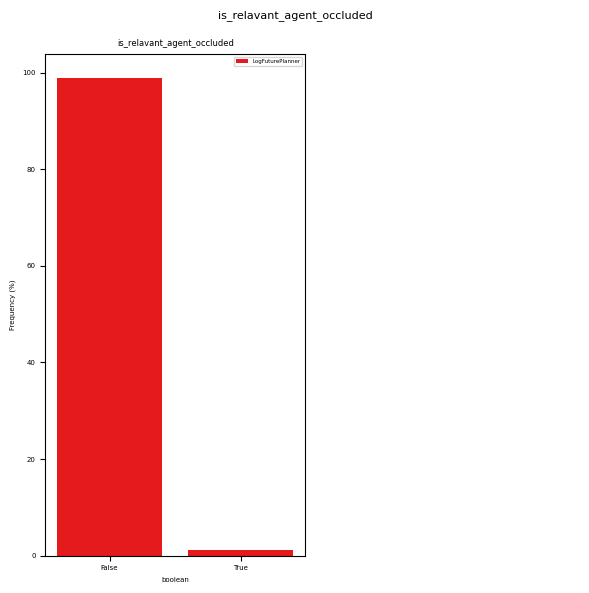

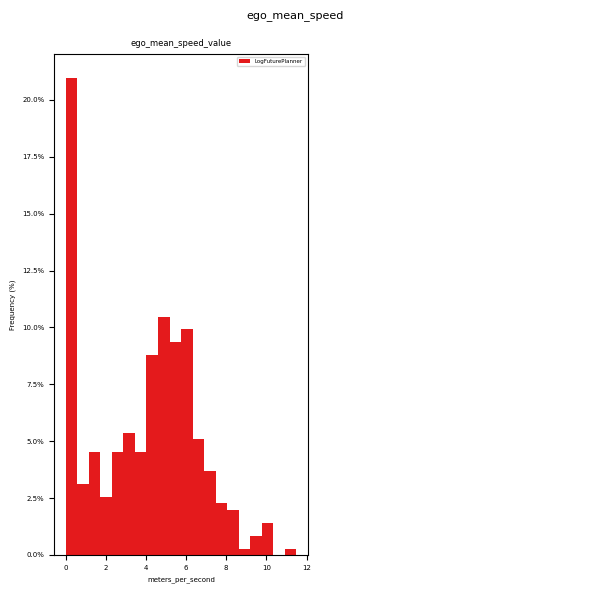

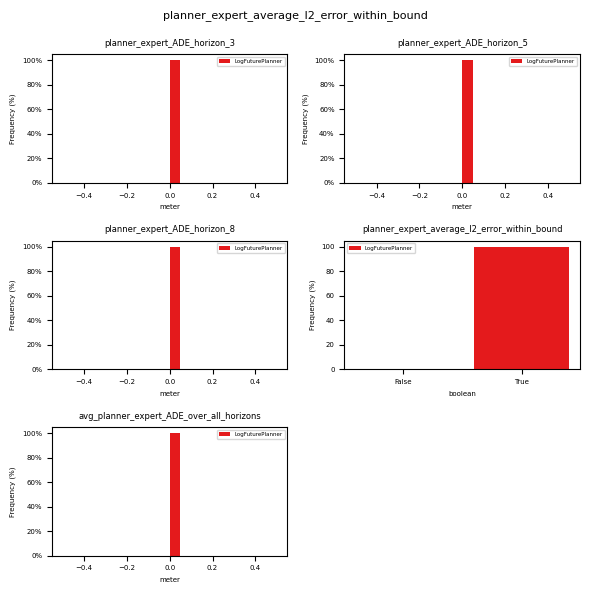

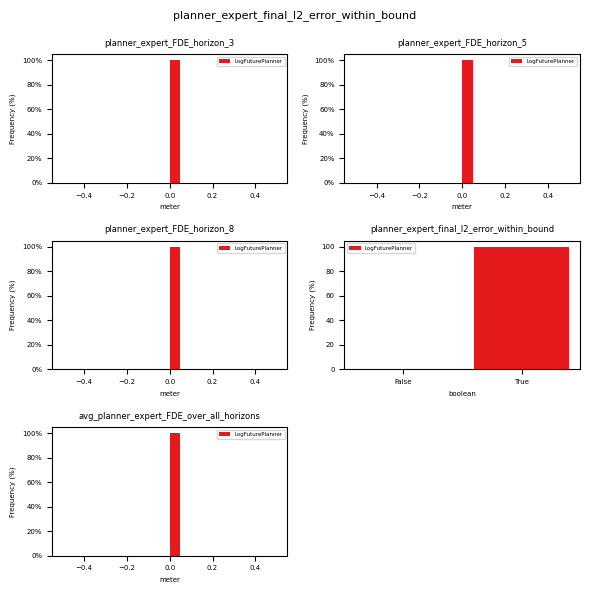

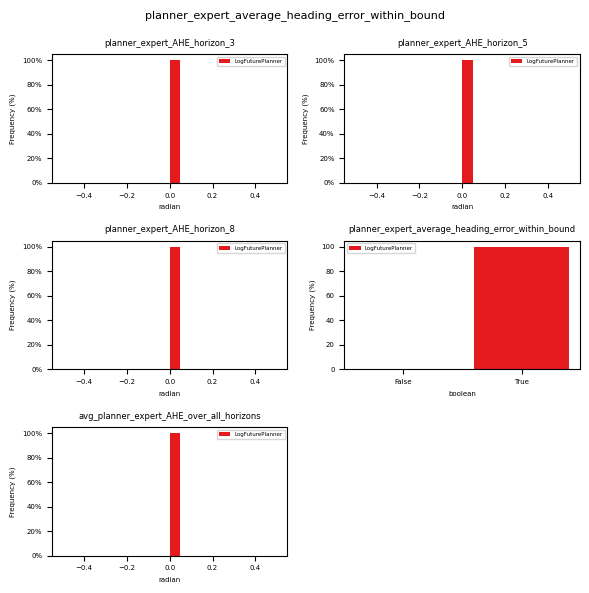

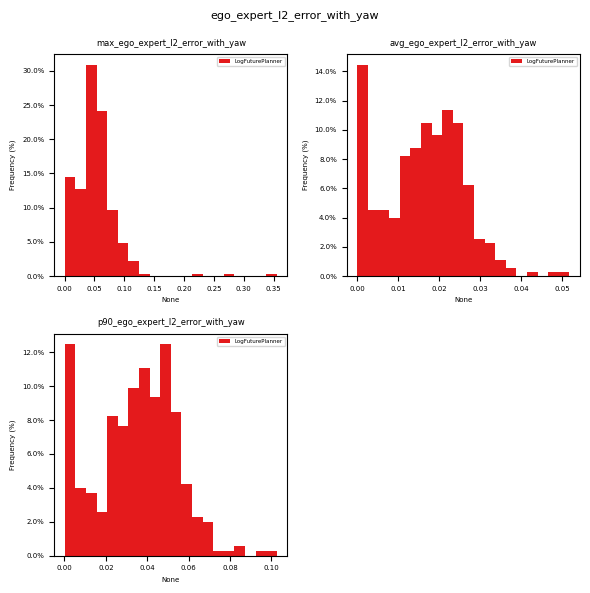

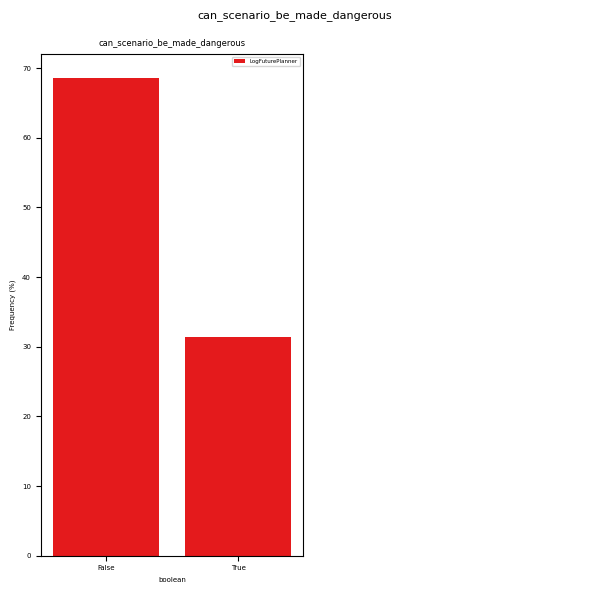

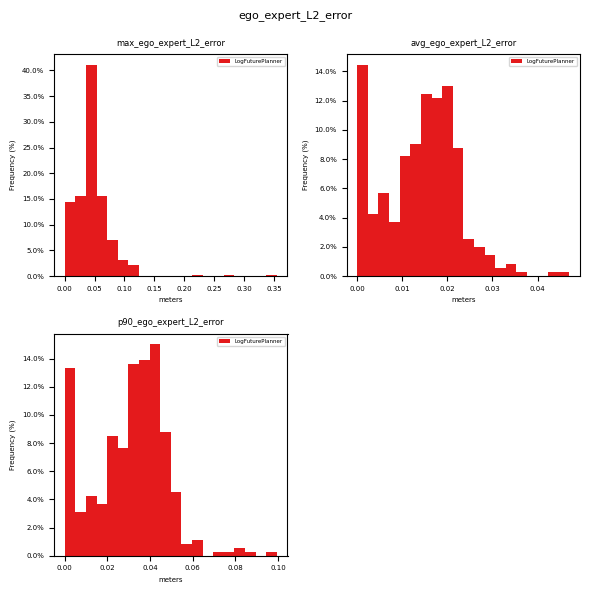

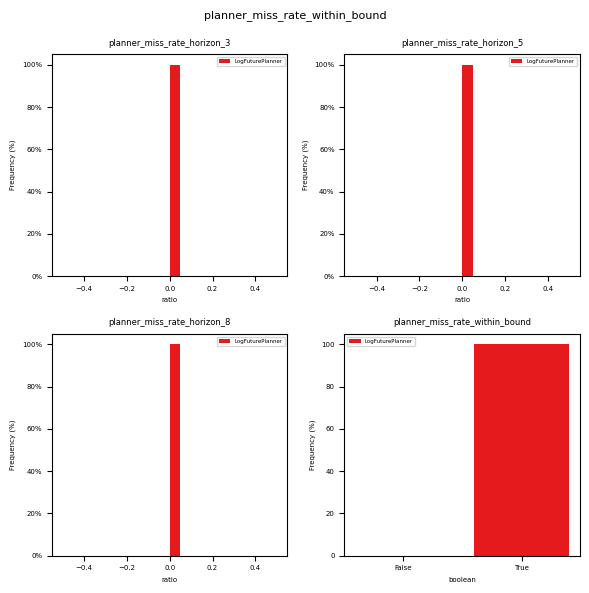

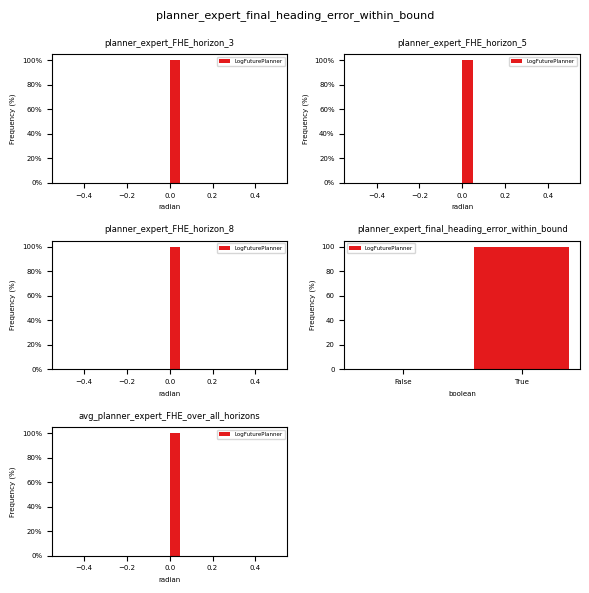

In [6]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

## Prepare the nuBoard config

In [7]:
output_folder_alt = []
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"
)

In [8]:
# output_folder = '../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.09.21.19.06'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# Location of path with all nuBoard configs
CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

## Launch nuBoard (open in new tab - recommended)

In [9]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2023-12-18 00:38:51,482 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-12-18 00:38:51,501 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-12-18 00:38:51,502 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-12-18 00:38:51,503 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2023-12-18 00:38:51,503 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2023-12-18 00:38:51,503 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 271.10ms


2023-12-18 00:38:53,069 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.67ms
2023-12-18 00:38:53,069 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2023-12-18 00:38:53,069 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


INFO:tornado.access:101 GET /ws (127.0.0.1) 0.67ms


2023-12-18 00:38:53,603 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-12-18 00:38:53,685 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0025 seconds.
2023-12-18 00:38:53,778 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 259.40ms


INFO:tornado.access:200 GET / (127.0.0.1) 259.40ms
Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 60.20it/s]


2023-12-18 00:41:17,082 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 1.9808 seconds.


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 37.95it/s]


2023-12-18 00:54:43,244 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 1.9161 seconds.
